# Sentiment Analysis: Real or Not? NLP with Disaster Tweets
Melvin D. Macapinlac

## Background
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

## The Dataset
The dataset was obtained from Kaggle. Each sample in the dataset has the following information:

1. The `text` of a tweet
2. A `keyword` from that tweet (although this may be blank!)
3. The `location` the tweet was sent from (may also be blank)

Here, the goal is to predict whether a given tweet is about a real disaster or not. If so, predict a `1`. If not, predict a `0`.

## Model

In this notebook, we will compare the following:

1. Sentiment Analysis by machine Learning classifier(either SVM or Naïve Bayes)
2. Sentiment Analysis by opinion Lexicon
              Adv+verb combination
              Adj+adv+verb combination
3. Compare the accuracy of Machine learning based SA with lexicon-based SA


#### 1. Load the dataset

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### 2. Check distribution of dataset

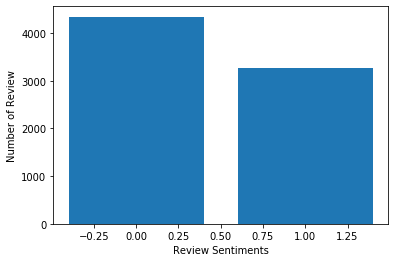

In [5]:
import matplotlib.pyplot as plt

Sentiment_count=df.groupby('target').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['text'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

In [6]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### I. Sentiment Analysis by Machine Learning Classifier (NB) - Count Vectorizer
For this model, we will use RegexpTokenizer to remove unwanted elements from the data like symbols and numbers. We will be converting the text to lowercase, remove stop words and tokenize the text by extracting unigrams.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import re

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
print(token)

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)

text_counts= cv.fit_transform(df['text'])
text_counts

RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)


<7613x21295 sparse matrix of type '<class 'numpy.int64'>'
	with 80841 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['target'], test_size=0.3, random_state=1)

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print(predicted)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

[1 0 0 ... 0 0 0]
MultinomialNB Accuracy: 0.7946584938704028


Using Multinomial Naive Bayes with feature generation using Bag-of-Words, we got an accuracy of **79.47%**

### II. Sentiment Analysis by Machine Learning Classifier (NB) - TFIDF Vectorizer

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_tf= tf.fit_transform(df['text'])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['target'], test_size=0.3, random_state=123)

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.803415061295972


Using Multinomial Naive Bayes with feature generation using Bag-of-Words, we got an accuracy of **80.34%**

### III. Sentiment Analysis by Opinion Lexicon

In [39]:
import nltk
from nltk.corpus import opinion_lexicon
from sklearn.metrics import accuracy_score

def pos_lex_sentiment(lines, adj=True, verb=True, adverb=True):
    
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank
    
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(lines)]
    part = nltk.pos_tag(tokenized_sent)
    
    new_text = []
    if adj:
        new_text.extend([p[0] for p in part if p[1].startswith('JJ')])
    if verb:
        new_text.extend([p[0] for p in part if p[1].startswith('VB')])
    if adverb:
        new_text.extend([p[0] for p in part if p[1].startswith('RB')])
    if (not adj) and not verb and not adverb:
        new_text.extend(tokenized_sent)
    
    y = []
    for word in new_text:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) #positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) #negative
        else:
            y.append(0) #neutral

    if sum(y)==0:
        return 0 # we consider this positive instead of neutral as the baseline does not contain neutral tweets
    elif sum(y)<0:
        return 1
    else:
        return 0

Filter only first 1000 rows for computational purposes.

In [40]:
df_lex = df[:1000]
df_lex.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Below, we will try various POS combinations and compare the accuracy scores.

#### a. Adverb + verb combination

In [41]:
df_lex['adv_plus_verb'] = df_lex['text'].apply(pos_lex_sentiment, adj=False, verb=True, adverb=True)
accuracy_score(df_lex['target'], df_lex['adv_plus_verb'])

0.674

#### b. Adjective + adverb + verb combination

In [42]:
df_lex['adj_adv_verb'] = df_lex['text'].apply(pos_lex_sentiment, adj=True, verb=True, adverb=True)
accuracy_score(df_lex['target'], df_lex['adj_adv_verb'])

0.656

#### c. Verb

In [43]:
df_lex['verb'] = df_lex['text'].apply(pos_lex_sentiment, adj=False, verb=True, adverb=False)
accuracy_score(df_lex['target'], df_lex['verb'])

0.681

#### d. Adjective

In [44]:
df_lex['adj'] = df_lex['text'].apply(pos_lex_sentiment, adj=True, verb=False, adverb=False)
accuracy_score(df_lex['target'], df_lex['adj'])

0.669

## Results

Using machine learning classifiers, we are able to get a test accuracy of **79.47%** and **80.34%** accuracy, using bag of words and TFIDF vectorizer feature generation, respectively.

Using Opinion Lexicon, we got the following results:
    
    a. adverb + verb combination = 67.4%
    b. adjective + adverb + verb combination = 65.6%
    c. verb only = 68.1%
    d. adjective only = 66.9%
    
Overall, we got better results using the Multinomial Naive Bayes classifier. Results can be further improved with other data cleaning and preprocessing methods.